# Generative Adversarial Network

Generative Adversarial Network 簡稱 GAN 中文是對抗式生成網路，是一個這幾年很紅的一個網路模型．是在 2014 年的這篇 [論文 by Ian Goodfellow](https://arxiv.org/abs/1406.2661) 被提出來的．

它理論的出發點很有趣，很普遍來解釋這個模型的例子是，可以先想像現在有一個製造偽鈔的罪犯，還有一個很會辨識偽鈔的鑑識人員．一個很厲害的偽鈔製作員的定義就是，它做出的偽鈔讓人無法分出和真的鈔票有什麼不一樣；而一個很會辨識的鑑識人員，則是可以分辨出每一張偽鈔．這一種競爭關係在 Game Theory 中被稱作 min max game．

而對抗式生成網路 (GAN) 就是這種關係在神經網中的實現．其中它包括了兩個神經網路，一個代表罪犯的生成式網路 (Generator)；另一個代表鑑識人員的鑑別式網路 (Discriminator)．生成式網路負責產生資料，而鑑別式網路負責判斷資料和真實資料的差異．它的輸出會是一個從 0 到 1 的數字，代表著輸入資料是真實資料的機率．例如輸出是 1 代表著它判斷 100% 這是真實資料，輸出是 0 代表這 100% 是假的資料．

理論上訓練到最後，當輸入生成式網路產出的資料給鑑別式網路，它的輸出會是 0.5，代表著它沒有辦法區分這是真實還是假的．

以下會利用 MNIST 資料集來嘗試訓練一個 GAN．

### Imports

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from libs.utils import weight_variable, bias_variable
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot = True)
%matplotlib inline

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


### Parameters

In [2]:
batch_size = 256
g_dim = 128

In [3]:
x_d = tf.placeholder(tf.float32, shape = [None, 784])
x_g = tf.placeholder(tf.float32, shape = [None, 128])

weights = {
    "w_d1" : weight_variable([784, 128], "w_d1"),
    "w_d2" : weight_variable([128, 1], "w_d2"),
    "w_g1" : weight_variable([128, 256], "w_g1"),
    "w_g2" : weight_variable([256, 784], "w_g2")
}

biases = {
    "b_d1" : bias_variable([128], "b_d1"),
    "b_d2" : bias_variable([1], "b_d2"),
    "b_g1" : bias_variable([256], "b_g1"),
    "b_g2" : bias_variable([784], "b_g2"),
}

var_d = [weights["w_d1"], weights["w_d2"], biases["b_d1"], biases["b_d2"]]
var_g = [weights["w_g1"], weights["w_g2"], biases["b_g1"], biases["b_g2"]]


### Build generator and discriminator networks

一個 GAN 裡包含了兩個神經網路，一個是 generator，另一個是 discriminator．首先照著定義個別建立網路．

生成式網路 `generator(z)` 會接受一個 128 維的輸入 z 並經過兩層網路以後產生一個 784 維的輸出，這就是所謂假的 MNIST 資料．

判斷式網路 `discrimination(x)` 接受一個 784 維的輸入 x 並經過兩層網路以後產生一個 1 維的輸出，而輸出經過 sigmoid 之後是一個 0 ~ 1 的數，代表著判斷式網路此輸出 x 是真實資料的機率．

In [4]:
def generator(z):
    h_g1 = tf.nn.relu(tf.add(tf.matmul(z, weights["w_g1"]), biases["b_g1"]))
    h_g2 = tf.nn.sigmoid(tf.add(tf.matmul(h_g1, weights["w_g2"]),biases["b_g2"]))
    return h_g2


def discriminator(x):
    h_d1 = tf.nn.relu(tf.add(tf.matmul(x, weights["w_d1"]), biases["b_d1"]))
    h_d2 = tf.nn.sigmoid(tf.add(tf.matmul(h_d1, weights["w_d2"]), biases["b_d2"]))
    return h_d2

### Build cost functions

在定義訓練 cost 函數的時候，和之前的神經網路比較不一樣的地方是它沒有一個標準的 loss 計算．畢竟這個模型要判斷的問題是真或假的問題．可以參考以下從[論文](https://arxiv.org/abs/1406.2661)摘錄出來的演算法片段，我們可以從以下步驟一一來看．


![](https://github.com/c1mone/Tensorflow-101/blob/master/notebooks/images/13_Generative_Adversarial_Network/GAN_algorithm.jpg?raw=true)



#### 計算 discriminator cost

- 一開始先要從一個 noise prior 取樣出資料給 generator 產生 MNIST 假資料，然後再把假資料丟給 discriminator 產生輸出稱作 `d_fake`．這裡使用 `uniform 分佈`當作 prior．
- 把真正的訓練資料丟給 discriminator 產生輸出稱作 `d_real`．
- 定義 discriminator 的 loss 為 `-tf.reduce_mean(tf.log(d_real) + tf.log(1. - d_fake))`，其意義為要讓 `d_real` 和 `1 - d_fake` 越大越好，而加上負號讓 tensorflow 去做最小化．

#### 計算 generator cost

- 最小化 `1 - d_fake` 也就是讓 geneartor 產生的輸出越不被判斷成假的越好．
- 論文中後來有一段說明最小化 `-d_fake` 會比直接最小化 `1 - d_fake` 來得好，因此這裡使用前者．

In [5]:
def sample_Z(m, n):
    return np.random.uniform(-1., 1., size=[m, n])

g_sample = generator(x_g)
d_real= discriminator(x_d)
d_fake = discriminator(g_sample)

d_loss = -tf.reduce_mean(tf.log(d_real) + tf.log(1. - d_fake))
g_loss = -tf.reduce_mean(tf.log(d_fake))

### Training 

接下來使用 AdamOptimizer 來做訓練，其中提到了要先對 discriminator 更新參數再對 geneartor 更新．因此需要在其中指定更新參數 `var_list`．

In [6]:
# 只更新 discriminator
d_optimizer = tf.train.AdamOptimizer(0.0005).minimize(d_loss, var_list= var_d)
# 只更新 generator parameters
g_optimizer = tf.train.AdamOptimizer(0.0001).minimize(g_loss, var_list= var_g)

In [7]:
def plot(samples):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)
    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap = 'gray')

    plt.show()

讓我們對其做 20000 次訓練，每 2000 次觀察 generator 輸出的結果．

step 0, discriminator loss 1.69854  generator loss 1.50697


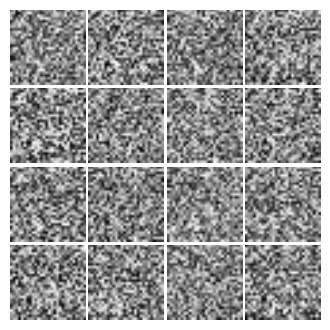

step 100, discriminator loss 0.02105  generator loss 5.91726
step 200, discriminator loss 0.01915  generator loss 6.58675
step 300, discriminator loss 0.08829  generator loss 4.98141
step 400, discriminator loss 0.12522  generator loss 3.94451
step 500, discriminator loss 0.08411  generator loss 4.59359
step 600, discriminator loss 0.03992  generator loss 5.07491
step 700, discriminator loss 0.02336  generator loss 5.24649
step 800, discriminator loss 0.02547  generator loss 4.81976
step 900, discriminator loss 0.03401  generator loss 4.83940
step 1000, discriminator loss 0.04611  generator loss 5.42968


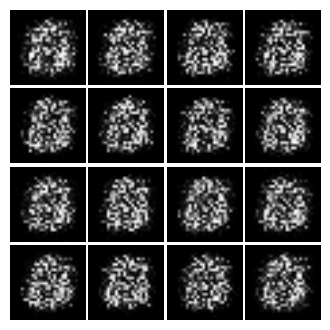

step 2000, discriminator loss 0.02058  generator loss 6.19514


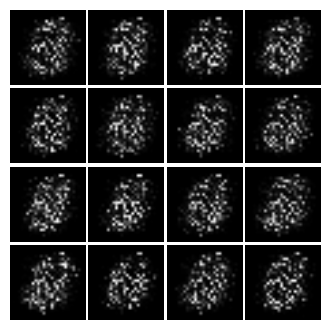

step 3000, discriminator loss 0.03554  generator loss 5.14732
step 4000, discriminator loss 0.02936  generator loss 6.21211


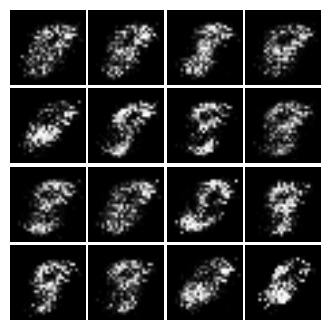

step 5000, discriminator loss 0.05945  generator loss 5.61464
step 6000, discriminator loss 0.07699  generator loss 6.15091


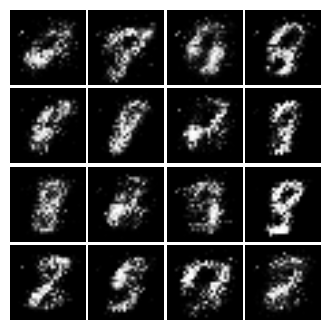

step 7000, discriminator loss 0.09617  generator loss 5.44982
step 8000, discriminator loss 0.22989  generator loss 5.43957


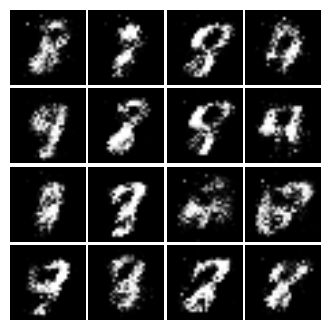

step 9000, discriminator loss 0.12218  generator loss 4.57952
step 10000, discriminator loss 0.24000  generator loss 4.42710


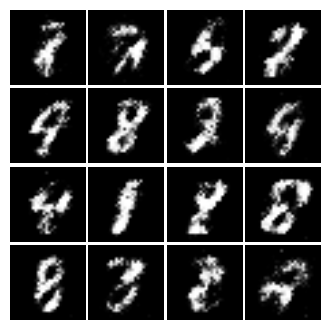

step 11000, discriminator loss 0.18720  generator loss 4.53043
step 12000, discriminator loss 0.30363  generator loss 4.57338


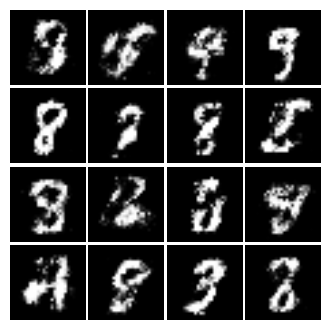

step 13000, discriminator loss 0.25502  generator loss 4.22321
step 14000, discriminator loss 0.24274  generator loss 4.36683


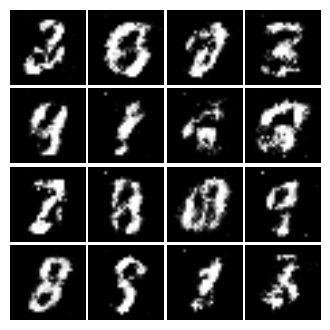

step 15000, discriminator loss 0.31198  generator loss 4.60863
step 16000, discriminator loss 0.33660  generator loss 4.08293


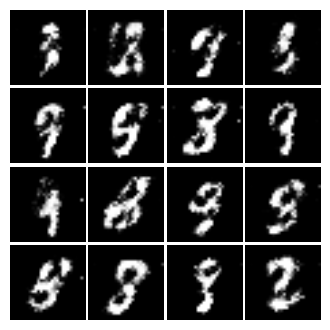

step 17000, discriminator loss 0.41924  generator loss 3.87464
step 18000, discriminator loss 0.23020  generator loss 4.31049


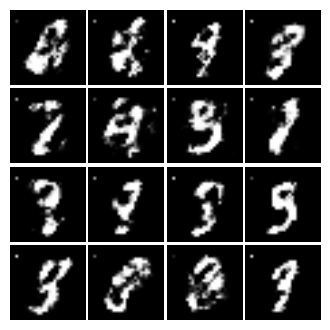

step 19000, discriminator loss 0.30502  generator loss 4.32447
step 20000, discriminator loss 0.25217  generator loss 3.92429


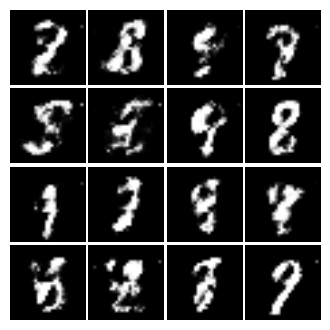

In [9]:
sess = tf.InteractiveSession()
init_op = tf.global_variables_initializer()
sess.run(init_op)
for step in range(20001):
    batch_x = mnist.train.next_batch(batch_size)[0]
    _, d_loss_train = sess.run([d_optimizer, d_loss], feed_dict = {x_d: batch_x, x_g: sample_Z(batch_size, g_dim)})
    _, g_loss_train = sess.run([g_optimizer, g_loss], feed_dict = {x_g: sample_Z(batch_size, g_dim)})

    if step <= 1000:
        if step % 100 == 0:
            print("step %d, discriminator loss %.5f" % (step, d_loss_train)),
            print(" generator loss %.5f" % (g_loss_train))
        if step % 1000 == 0: 
            g_sample_plot = g_sample.eval(feed_dict = {x_g: sample_Z(16, g_dim)})
            plot(g_sample_plot)
    else:
        if step % 1000 == 0:
            print("step %d, discriminator loss %.5f" % (step, d_loss_train)),
            print(" generator loss %.5f" % (g_loss_train))
        if step % 2000 == 0: 
            g_sample_plot = g_sample.eval(feed_dict = {x_g: sample_Z(16, g_dim)})
            plot(g_sample_plot)



Bingo! 可以看到 generator 輸出的影像和 MNIST 資料越來越像，但會有許多模糊的殘影．以下是 gif 檔

![gif](https://github.com/c1mone/Tensorflow-101/blob/master/notebooks/images/13_Generative_Adversarial_Network/GAN_result.gif?raw=true)

## 小結

我們使用了 tensorflow 實現了 GAN 的組成的兩個神經網路，並用 MNIST 來測驗其對抗式生成的過程．

其中遇到比較大的問題是，一開始把學習參數調整得太大，因此會造成網路崩潰，後來學到一開始的學習參數要調整的比較小一點．還有一個問題是，很難從 loss 中看出現在 generator 的效果如何，目前發現有一個規律是如果 discriminator 的 loss 太快變成 0 就表示網路崩潰．

而 20000 次的訓練可以讓 generator 產生有點形狀但模糊的影像，但是還沒有辦法做到很完美的地步，例如數字邊緣的利銳度就不太夠．

### 問題

- 如果讓 generator 變得更複雜 (ex. 3 層)，會不會有比較好的效果?
- 取樣換成別種機率分佈，會不會學得比較快?
- 如果把 VAE 的 decoder 拿來當 GAN 的初始參數會不會訓練的比較快?


## 學習資源連結

- [Generative Adversarial Netork](https://arxiv.org/abs/1406.2661)
- [GAN tensorflow blog post](http://wiseodd.github.io/techblog/2016/09/17/gan-tensorflow)
- [Tips and tricks to make GAN](https://github.com/soumith/ganhacks)